In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import warnings


pd.set_option('display.max_columns', 10)
pd.options.mode.chained_assignment = None

# Suppress both SettingWithCopyWarning and FutureWarnings related to ChainedAssignmentError
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ticker = 'SPY'
data = yf.download(ticker, start='2020-01-01', end='2024-09-30')
data.index = pd.to_datetime(data.index)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,302.208588,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,299.920258,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,301.064453,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,300.217834,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,301.817932,68296000
...,...,...,...,...,...,...
2024-09-23,569.340027,570.330017,568.099976,569.669983,569.669983,44116900
2024-09-24,570.479980,571.359985,567.599976,571.299988,571.299988,46805700
2024-09-25,571.140015,571.890015,568.909973,570.039978,570.039978,38428600


In [3]:
fast_MA_period = 50
slow_MA_period = 100
adx_period = 14
adx_threashold = 20
# Calculating technicals and drop the NA
data[f'MA_fast'] = data['Adj Close'].rolling(window=fast_MA_period).mean()
data[f'MA_slow'] = data['Adj Close'].rolling(window=200).mean()
data['ADX'] = data.ta.adx(length=adx_period)[f'ADX_{adx_period}']
data.dropna(inplace=True)
data


,Open,High,Low,Close,Adj Close,Volume,MA_fast,MA_slow,ADX
Date,,,,,,,,,
2020-10-15,343.709991,348.019989,343.130005,347.500000,327.899078,60357700,319.193788,291.878136,18.712061
2020-10-16,348.959991,350.750000,347.100006,347.290009,327.701019,89501900,319.463524,292.005598,18.563394
2020-10-19,348.649994,349.329987,341.040009,342.010010,322.718903,68425600,319.629106,292.119591,17.246763
2020-10-20,343.459991,346.880005,342.640015,343.380005,324.011566,60051900,319.801745,292.234327,16.024177
2020-10-21,343.329987,345.670013,342.399994,342.730011,323.398285,63575000,320.014186,292.350229,14.916444
...,...,...,...,...,...,...,...,...,...
2024-09-23,569.340027,570.330017,568.099976,569.669983,569.669983,44116900,549.167953,516.002538,18.457141
2024-09-24,570.479980,571.359985,567.599976,571.299988,571.299988,46805700,549.397694,516.615575,18.897457
2024-09-25,571.140015,571.890015,568.909973,570.039978,570.039978,38428600,549.535840,517.205193,19.384058


In [4]:
# Determine the trend based on ADX and Moving Averages
def identify_trend(row):
    if row['ADX'] > adx_threashold and row['MA_fast'] > row['MA_slow']:
        return 1
    elif row['ADX'] > adx_threashold and row['MA_fast'] < row['MA_slow']:
        return -1
    else:
        return 0

data['Signal'] = data.apply(identify_trend, axis=1)
#count values per position
data['Signal'].value_counts()

Signal
 1    456
 0    400
-1    138
Name: count, dtype: int64

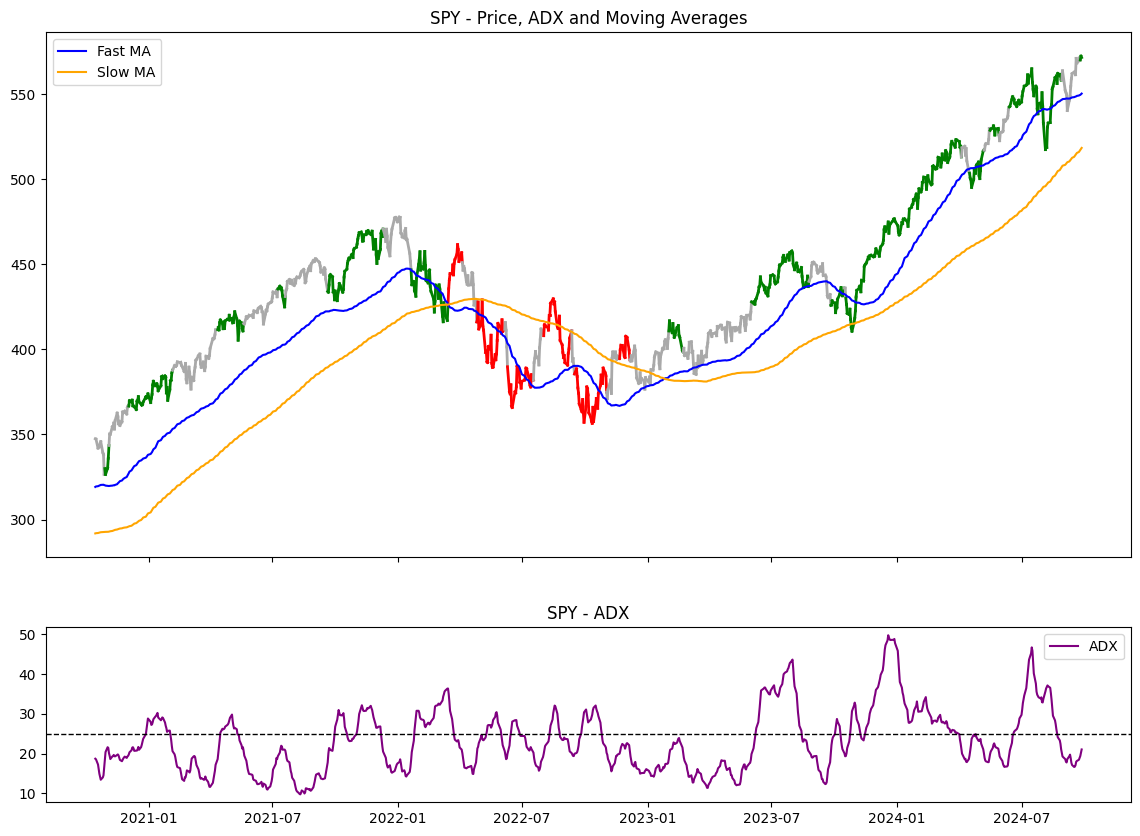

In [5]:
df = data.copy()
# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Signal'].iloc[i] == 1 else 
                   ('red' if df['Signal'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_fast'], label='Fast MA', color='blue')
ax1.plot(df['MA_slow'], label='Slow MA', color='orange')
ax1.set_title(f'{ticker} - Price, ADX and Moving Averages')
ax1.legend(loc='best')

# Plot ADX on the second subplot (smaller height)
ax2.plot(df.index, df['ADX'], label='ADX', color='purple')
ax2.axhline(25, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at ADX=25
ax2.set_title(f'{ticker} - ADX')
ax2.legend(loc='best')

plt.show()

In [6]:
def calculate_returns(df_for_returns, col_for_returns = 'Adj Close', col_for_signal = 'Trend'):

    stats = {}

    # Calculate daily returns
    df_for_returns['Daily_Returns'] = df_for_returns[col_for_returns].pct_change()
    df_for_returns['Returns'] = df_for_returns['Daily_Returns'] * df_for_returns[col_for_signal].shift(1)
    df_for_returns['Returns'] = df_for_returns['Returns'].fillna(0)
    df_for_returns['Equity_Curve'] = 100 * (1 + df_for_returns['Returns']).cumprod()


    return df_for_returns

data = calculate_returns(data, col_for_returns = 'Adj Close', col_for_signal = 'Signal')
data

,Open,High,Low,Close,Adj Close,...,ADX,Signal,Daily_Returns,Returns,Equity_Curve
Date,,,,,,,,,,,
2020-10-15,343.709991,348.019989,343.130005,347.500000,327.899078,...,18.712061,0,NaN,0.00000,100.000000
2020-10-16,348.959991,350.750000,347.100006,347.290009,327.701019,...,18.563394,0,-0.000604,-0.00000,100.000000
2020-10-19,348.649994,349.329987,341.040009,342.010010,322.718903,...,17.246763,0,-0.015203,-0.00000,100.000000
2020-10-20,343.459991,346.880005,342.640015,343.380005,324.011566,...,16.024177,0,0.004006,0.00000,100.000000
2020-10-21,343.329987,345.670013,342.399994,342.730011,323.398285,...,14.916444,0,-0.001893,-0.00000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,569.340027,570.330017,568.099976,569.669983,569.669983,...,18.457141,0,0.002499,0.00000,163.327258
2024-09-24,570.479980,571.359985,567.599976,571.299988,571.299988,...,18.897457,0,0.002861,0.00000,163.327258
2024-09-25,571.140015,571.890015,568.909973,570.039978,570.039978,...,19.384058,0,-0.002206,-0.00000,163.327258


In [7]:
def calculate_benchmark_returns(df_for_returns, col_for_returns = 'Adj Close'):

    stats = {}

    # Calculate daily returns
    df_for_returns['Benchmark_Returns'] = df_for_returns[col_for_returns].pct_change()
    df_for_returns['Benchmark_Returns'] = df_for_returns['Benchmark_Returns'].fillna(0)
    df_for_returns['Benchmark_Equity_Curve'] = 100 * (1 + df_for_returns['Benchmark_Returns']).cumprod()

    return df_for_returns

data  = calculate_benchmark_returns(data, col_for_returns = 'Adj Close')
data

,Open,High,Low,Close,Adj Close,...,Daily_Returns,Returns,Equity_Curve,Benchmark_Returns,Benchmark_Equity_Curve
Date,,,,,,,,,,,
2020-10-15,343.709991,348.019989,343.130005,347.500000,327.899078,...,NaN,0.00000,100.000000,0.000000,100.000000
2020-10-16,348.959991,350.750000,347.100006,347.290009,327.701019,...,-0.000604,-0.00000,100.000000,-0.000604,99.939598
2020-10-19,348.649994,349.329987,341.040009,342.010010,322.718903,...,-0.015203,-0.00000,100.000000,-0.015203,98.420192
2020-10-20,343.459991,346.880005,342.640015,343.380005,324.011566,...,0.004006,0.00000,100.000000,0.004006,98.814418
2020-10-21,343.329987,345.670013,342.399994,342.730011,323.398285,...,-0.001893,-0.00000,100.000000,-0.001893,98.627385
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,569.340027,570.330017,568.099976,569.669983,569.669983,...,0.002499,0.00000,163.327258,0.002499,173.733328
2024-09-24,570.479980,571.359985,567.599976,571.299988,571.299988,...,0.002861,0.00000,163.327258,0.002861,174.230434
2024-09-25,571.140015,571.890015,568.909973,570.039978,570.039978,...,-0.002206,-0.00000,163.327258,-0.002206,173.846167


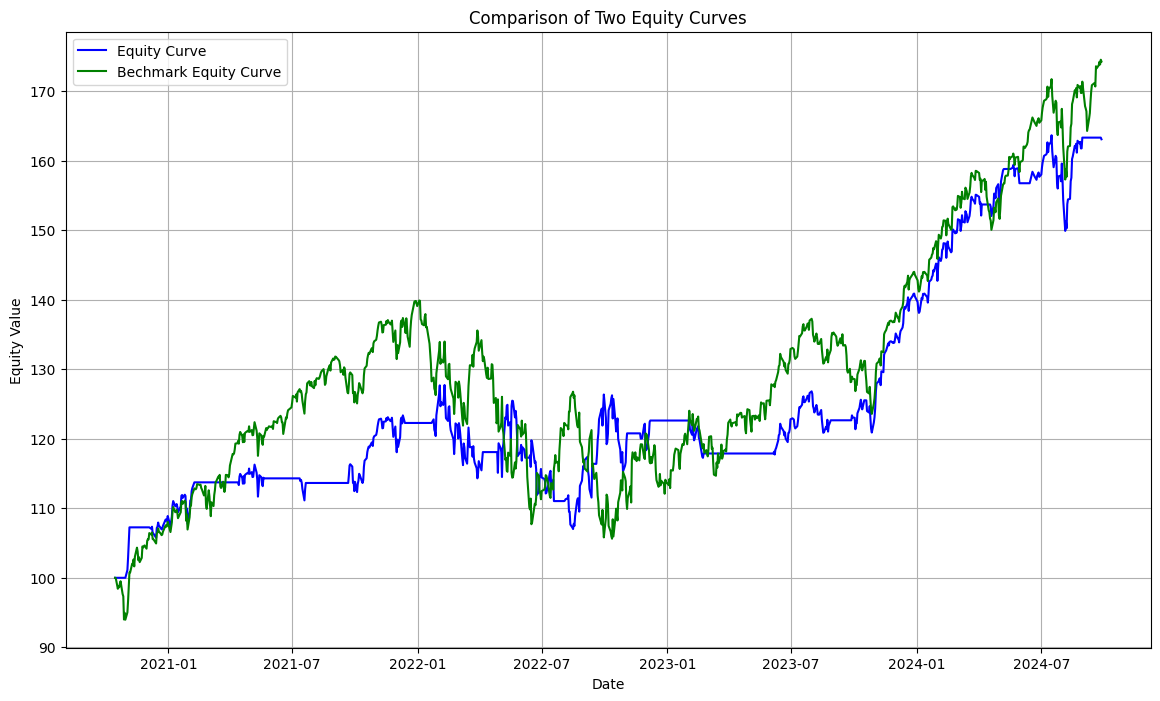

In [8]:
# Set up the figure and axes
plt.figure(figsize=(14, 8))

# Plot both equity curves
plt.plot(data.index, data['Equity_Curve'], label='Equity Curve', color='blue')
plt.plot(data.index, data['Benchmark_Equity_Curve'], label='Bechmark Equity Curve', color='green')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Comparison of Two Equity Curves')
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [9]:
# Compare Time Exposure
time_in_market = data['Signal'][data['Signal'] != 0].count() / len(data)
print(f"Strategy Time Exposure: {time_in_market * 100:.2f}%")

Strategy Time Exposure: 59.76%


In [10]:
# Set up the annual rates dictionary
annual_rates = {
    2020: 0.0025,
    2021: 0.0003,
    2022: 0.0210,
    2023: 0.0470,
    2024: 0.0530
}


# Create a new column that holds the difference in days between the current row and the previous one
data['Days_Difference'] = data.index.to_series().diff().dt.days
data['Days_Difference'] = data['Days_Difference'].fillna(1)

# Extract the year from the index and create a new column for the year
data['Year'] = data.index.year
# Calculate daily rates
daily_rates= {year: (1 + rate) ** (1 / 365) - 1 for year, rate in annual_rates.items()}
# Map the daily rates to the corresponding year and create a new column for the daily rate
data['Daily_Rate_Returns'] = data['Year'].map(daily_rates) * data['Days_Difference']

# Calculate the days that there is an open position
data['Open_Position'] = data['Signal'].shift(1)
# data['Open_Position'] = data['Signal'].shift(1)
data['Open_Position'] = data['Open_Position'].fillna(0)

data['Returns_Combined'] = data.apply(lambda row: row['Open_Position'] * row['Daily_Returns'] if row['Open_Position'] != 0 else row['Daily_Rate_Returns'], axis=1)

data['Returns_Combined'] = data['Returns_Combined'].fillna(0)
data['Equity_Curve_including_interest'] = 100 * (1 + data['Returns_Combined']).cumprod()

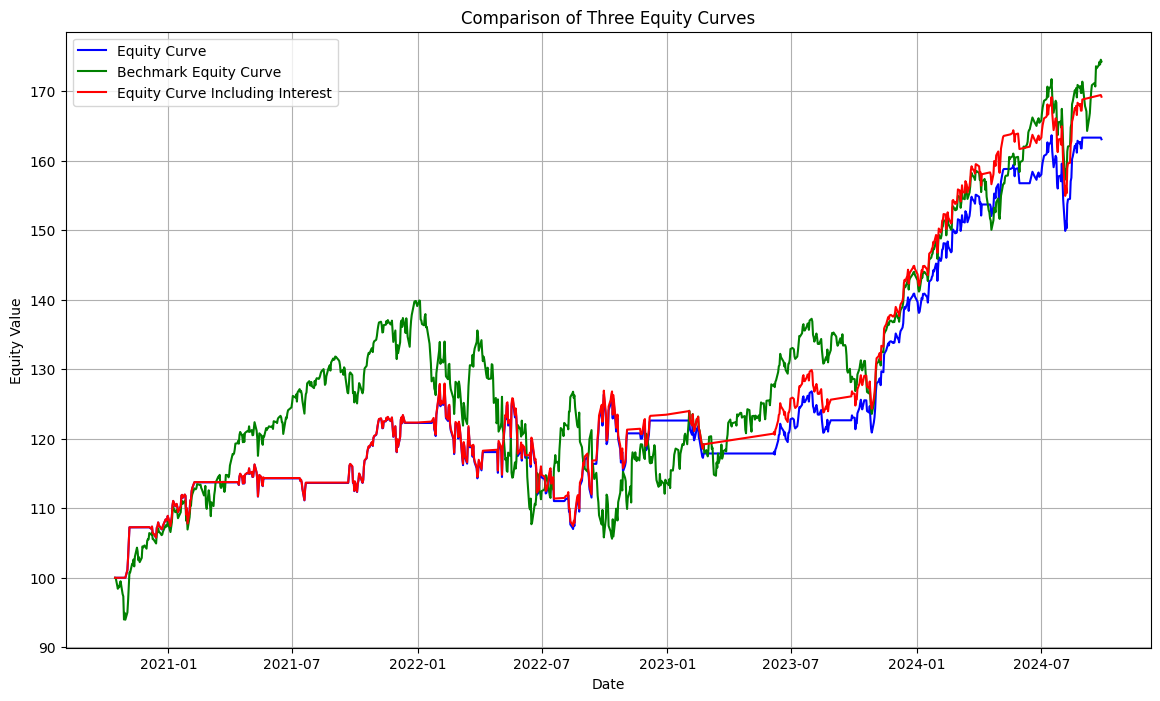

In [11]:
# Set up the figure and axes
plt.figure(figsize=(14, 8))

# Plot both equity curves
plt.plot(data.index, data['Equity_Curve'], label='Equity Curve', color='blue')
plt.plot(data.index, data['Benchmark_Equity_Curve'], label='Bechmark Equity Curve', color='green')
plt.plot(data.index, data['Equity_Curve_including_interest'], label='Equity Curve Including Interest', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Comparison of Three Equity Curves')
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [13]:
def max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = drawdown.cummin()
    return max_drawdown.min()

max_dd_strategy = max_drawdown(data['Equity_Curve'])
max_dd_market = max_drawdown(data['Benchmark_Equity_Curve'])
max_dd_market_combined = max_drawdown(data['Equity_Curve_including_interest'])

print(f"Strategy Maximum Drawdown: {max_dd_strategy * 100:.2f}%")
print(f"Benchmark Maximum Drawdown: {max_dd_market * 100:.2f}%")
print(f"Strategy Combined Maximum Drawdown: {max_dd_market_combined * 100:.2f}%")

Strategy Maximum Drawdown: -16.22%
Benchmark Maximum Drawdown: -24.50%
Strategy Combined Maximum Drawdown: -16.02%


In [14]:
# Sharpe Ratio
annual_return_strategy = data['Returns'].mean() * 252
annual_volatility_strategy = data['Returns'].std() * np.sqrt(252)
sharpe_ratio_strategy = annual_return_strategy / annual_volatility_strategy

annual_return_market = data['Benchmark_Returns'].mean() * 252
annual_volatility_market = data['Benchmark_Returns'].std() * np.sqrt(252)
sharpe_ratio_market = annual_return_market / annual_volatility_market

annual_return_market_combined = data['Returns_Combined'].mean() * 252
annual_volatility_market_combined = data['Returns_Combined'].std() * np.sqrt(252)
sharpe_ratio_market_combined = annual_return_market_combined / annual_volatility_market_combined

print(f"Strategy Sharpe Ratio: {sharpe_ratio_strategy:.2f}")
print(f"Benchmark Sharpe Ratio: {sharpe_ratio_market:.2f}")
print(f"Strategy Combined Sharpe Ratio: {sharpe_ratio_market_combined:.2f}")

Strategy Sharpe Ratio: 0.99
Benchmark Sharpe Ratio: 0.93
Strategy Combined Sharpe Ratio: 1.06


In [15]:
# Downside Volatility
downside_volatility_strategy = data[data['Returns'] < 0]['Returns'].std() * np.sqrt(252)
sortino_ratio_strategy = annual_return_strategy / downside_volatility_strategy

downside_volatility_market = data[data['Benchmark_Returns'] < 0]['Benchmark_Returns'].std() * np.sqrt(252)
sortino_ratio_market = annual_return_market / downside_volatility_market


downside_volatility_market_combined = data[data['Benchmark_Returns'] < 0]['Benchmark_Returns'].std() * np.sqrt(252)
sortino_ratio_market_combined = annual_return_market_combined / downside_volatility_market_combined

print(f"Strategy Sortino Ratio: {sortino_ratio_strategy:.2f}")
print(f"Benchmark Sortino Ratio: {sortino_ratio_market:.2f}")
print(f"Strategy Combined Sortino Ratio: {sortino_ratio_market_combined:.2f}")

Strategy Sortino Ratio: 1.11
Benchmark Sortino Ratio: 1.31
Strategy Combined Sortino Ratio: 1.20


In [16]:
# Function to calculate volatility (standard deviation of returns)
def volatility(cumulative_returns):
    returns = cumulative_returns.pct_change().dropna()
    return returns.std()

# Assuming `data` is your DataFrame containing multiple equity curves
vol_strategy = volatility(data['Equity_Curve'])
vol_market = volatility(data['Benchmark_Equity_Curve'])
vol_market_combined = volatility(data['Equity_Curve_including_interest'])

print(f"Strategy Volatility: {vol_strategy:.4f}")
print(f"Benchmark Volatility: {vol_market:.4f}")
print(f"Strategy Combined Volatility: {vol_market_combined:.4f}")

Strategy Volatility: 0.0084
Benchmark Volatility: 0.0105
Strategy Combined Volatility: 0.0084
